## 数据质控


In [1]:
# 确保src目录在Python路径中
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath("../"))

# 导入模块
from src.data_utils import filter_anomalous_attributes, identify_attributes, parse_petrel_file
from src.feature_selection import select_best_features

output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# 设置中文字体
plt.rcParams["font.family"] = "SimHei"  # 黑体 SimHei 支持中文
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

## 导入地震数据


In [2]:
data_H6_2_attr = parse_petrel_file("../data/H6-2_attr")

正在解析文件: ../data/H6-2_attr
正在识别文件属性: ../data/H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
识别到的列含义: ['X', 'Y', 'Z', 'column', 'row']
数据行有 20 列，列名列表有 20 个


c:\Users\WangQinZhuo\Program\attribute_fusion_0526\src\data_utils.py:110: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


成功读取数据，共 51714 行

数据预览:
               X             Y            Z  column  row  Average energy  \
0  688546.288809  3.211900e+06 -2472.896240   128.0  1.0      3538352.25   
1  688596.288809  3.211900e+06 -2475.649902   129.0  1.0      6365790.00   
2  688446.288809  3.211950e+06 -2465.910889   126.0  2.0      9748781.00   
3  688496.288809  3.211950e+06 -2469.487061   127.0  2.0      5062806.00   
4  688546.288809  3.211950e+06 -2472.695801   128.0  2.0      2440221.75   

   Average envelope  Average instantaneous frequency  \
0       3114.544678                        32.982338   
1       3344.748779                        33.155682   
2       4269.621094                        35.096291   
3       3648.766113                        31.971563   
4       2865.032471                        31.293999   

   Average instantaneous phase  Average peak value  Geometric mean  \
0                   -75.810104              -999.0          -999.0   
1                   -86.797714            

## 导入井震数据


In [3]:
file_H6_2_well = "../data/well_processed.xlsx"
data_H6_2_well = pd.read_excel(file_H6_2_well, sheet_name="Sheet1")

# 只选择 Surface 为 H6-2 的行，并丢弃砂厚为 NaN 的行
data_H6_2_well_selected = (
    data_H6_2_well[data_H6_2_well["Surface"] == "H6-2"]
    .replace(-999, np.nan)
    .dropna(subset=["Thickness of facies(1: Fine sand)"])
    .reset_index(drop=True)
)

data_H6_2_well_selected.head()

,X,Y,Z,Surface,Well,Thickness of facies(1: Fine sand),facies(1: Fine sand),Average energy,Average envelope,Average instantaneous frequency,Average instantaneous phase,Half energy,Harmonic mean,Maximum amplitude,Mean amplitude,Minimum amplitude,Most of,RMS amplitude,Sum of amplitudes,Sum of energy
0,686325.6,3217019.1,-2649.7,H6-2,A1,0.00,0.00,89001976.0,11011.2,21.9,-151.88,5.2,-4573.6,-1763.2,-8415.1,-14124.2,-13431.1,9511.8,-66162.7,718160960
1,686616.5,3217415.2,-2633.0,H6-2,A10,7.87,45.82,76951152.0,11667.5,25.9,-113.60,4.0,-43402.7,4934.6,-4832.2,-15217.6,-13626.4,8764.0,-36986.6,724726848
2,686278.0,3217627.9,-2650.4,H6-2,A11,0.00,0.00,6199530.0,2127.4,49.7,-84.15,7.2,-1264.8,4551.3,623.9,-2246.4,-556.0,2459.4,2576.6,26151754
3,686149.5,3216665.5,-2642.5,H6-2,A2,0.75,5.16,88260688.0,12334.4,21.0,-132.54,4.0,-7747.0,1608.4,-7710.8,-15313.4,-14014.2,9393.7,-57804.2,667979712
4,685921.1,3216986.2,-2644.7,H6-2,A4,0.00,0.00,31338386.0,5349.9,25.9,13.58,7.0,3644.1,7899.5,4837.1,624.7,4900.9,5553.1,15000.3,97357456


## 提取共同属性


In [4]:
# 获取地震属性列表
seismic_attr, _ = identify_attributes("../data/H6-2_attr")

# 提取Excel的属性列表（从第8列开始的所有列）
well_seismic_attr = data_H6_2_well.columns[7:].tolist()

# 计算两个列表的交集
common_attributes = list(set(seismic_attr) & set(well_seismic_attr))

# 打印结果
print(f"地震属性数量: {len(seismic_attr)}")
print(f"Excel属性数量: {len(well_seismic_attr)}")
print(f"共同属性数量: {len(common_attributes)}")
print("\n共同属性列表:")
for attr in common_attributes:
    print(f"- {attr}")

正在识别文件属性: ../data/H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
地震属性数量: 15
Excel属性数量: 13
共同属性数量: 13

共同属性列表:
- Average instantaneous phase
- Maximum amplitude
- Most of
- RMS amplitude
- Average energy
- Sum of energy
- Average instantaneous frequency
- Sum of amplitudes
- Harmonic mean
- Average envelope
- Minimum amplitude
- Half energy
- Mean amplitude


## 根据井点分布，缩小工区范围

井点数据X轴范围: 685921.10 到 688921.10
井点数据Y轴范围: 3216119.60 到 3223692.60
原始地震数据点数: 51714
缩小范围后的地震数据点数: 9806
数据量减少了: 81.04%


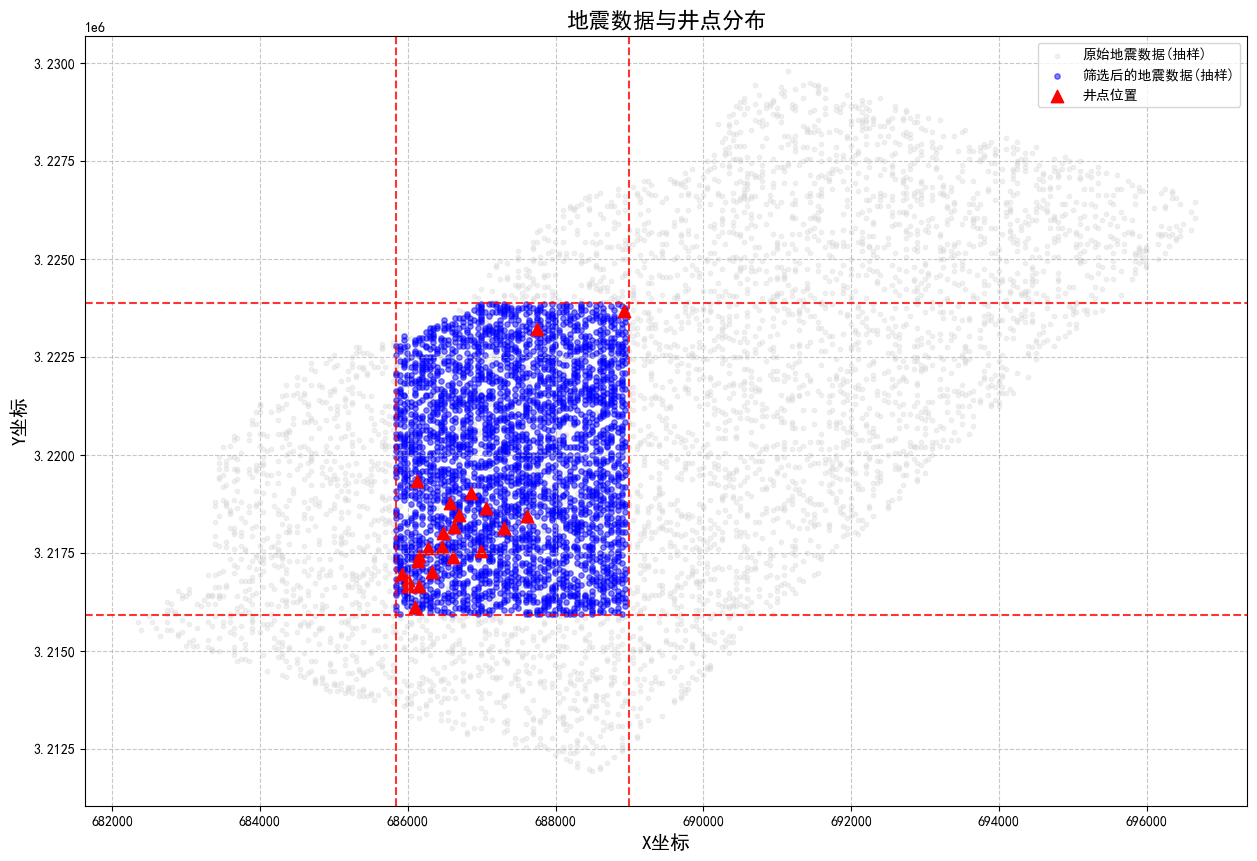

In [5]:
# 根据井点分布缩小工区范围
# 获取井点数据的X、Y范围
well_x_min = data_H6_2_well_selected["X"].min()
well_x_max = data_H6_2_well_selected["X"].max()
well_y_min = data_H6_2_well_selected["Y"].min()
well_y_max = data_H6_2_well_selected["Y"].max()

# 打印井点区域范围
print(f"井点数据X轴范围: {well_x_min:.2f} 到 {well_x_max:.2f}")
print(f"井点数据Y轴范围: {well_y_min:.2f} 到 {well_y_max:.2f}")

# 可选：为了展示井点聚集区域，可以扩大一定比例
expansion_factor = 1.05  # 扩展5%
x_padding = (well_x_max - well_x_min) * (expansion_factor - 1) / 2
y_padding = (well_y_max - well_y_min) * (expansion_factor - 1) / 2

# 应用扩展后的范围
well_area_x_min = well_x_min - x_padding
well_area_x_max = well_x_max + x_padding
well_area_y_min = well_y_min - y_padding
well_area_y_max = well_y_max + y_padding

# 筛选出井点范围内的地震数据
data_H6_2_attr_filtered = data_H6_2_attr[
    (data_H6_2_attr["X"] >= well_area_x_min)
    & (data_H6_2_attr["X"] <= well_area_x_max)
    & (data_H6_2_attr["Y"] >= well_area_y_min)
    & (data_H6_2_attr["Y"] <= well_area_y_max)
].copy()

# 统计过滤前后的数据量
original_size = len(data_H6_2_attr)
filtered_size = len(data_H6_2_attr_filtered)
reduction_percent = (1 - filtered_size / original_size) * 100

print(f"原始地震数据点数: {original_size}")
print(f"缩小范围后的地震数据点数: {filtered_size}")
print(f"数据量减少了: {reduction_percent:.2f}%")

# 可视化原始数据与筛选后的数据分布
plt.figure(figsize=(15, 10))

# 绘制地震数据点（使用抽样以避免过多点导致图像渲染缓慢）
sample_ratio = min(1.0, 5000 / len(data_H6_2_attr))
seismic_sample = data_H6_2_attr.sample(frac=sample_ratio)
plt.scatter(seismic_sample["X"], seismic_sample["Y"], color="lightgray", alpha=0.3, s=10, label="原始地震数据(抽样)")

# 绘制筛选后的地震数据
filtered_sample_ratio = min(1.0, 3000 / len(data_H6_2_attr_filtered))
filtered_sample = data_H6_2_attr_filtered.sample(frac=filtered_sample_ratio)
plt.scatter(filtered_sample["X"], filtered_sample["Y"], color="blue", alpha=0.5, s=15, label="筛选后的地震数据(抽样)")

# 绘制井点位置
plt.scatter(data_H6_2_well_selected["X"], data_H6_2_well_selected["Y"], color="red", s=80, marker="^", label="井点位置")

# 绘制筛选边界框
plt.axvline(x=well_area_x_min, color="red", linestyle="--", alpha=0.8)
plt.axvline(x=well_area_x_max, color="red", linestyle="--", alpha=0.8)
plt.axhline(y=well_area_y_min, color="red", linestyle="--", alpha=0.8)
plt.axhline(y=well_area_y_max, color="red", linestyle="--", alpha=0.8)

# 添加标题和图例
plt.title("地震数据与井点分布", fontsize=16)
plt.xlabel("X坐标", fontsize=14)
plt.ylabel("Y坐标", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.7)

# 保存图片
plt.savefig(os.path.join(output_dir, "seismic_well_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()

## 生成统计摘要


======== 井点数据与地震数据的属性统计比较 ========

共分析了 13 个共同属性
发现 2 个异常属性
保留 11 个质量良好的属性

异常属性及原因:
  - Harmonic mean: 均值比值异常 (14.6243), 标准差比值异常 (232.3925), 数值范围比值异常 (4729.9646)
  - Sum of amplitudes: 均值比值为负 (-0.4365)


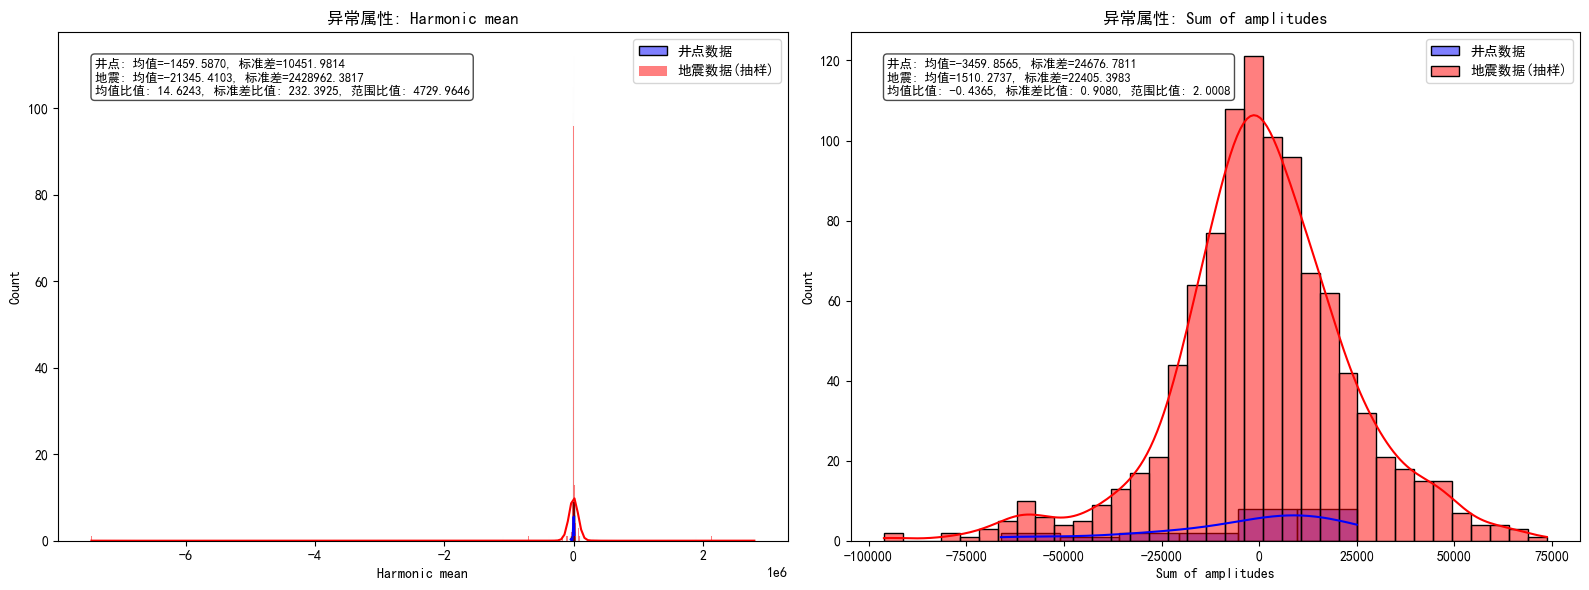

c:\Users\WangQinZhuo\Program\attribute_fusion_0526\src\data_utils.py:371: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="属性", y="质量分数", data=plot_df, palette=colors)


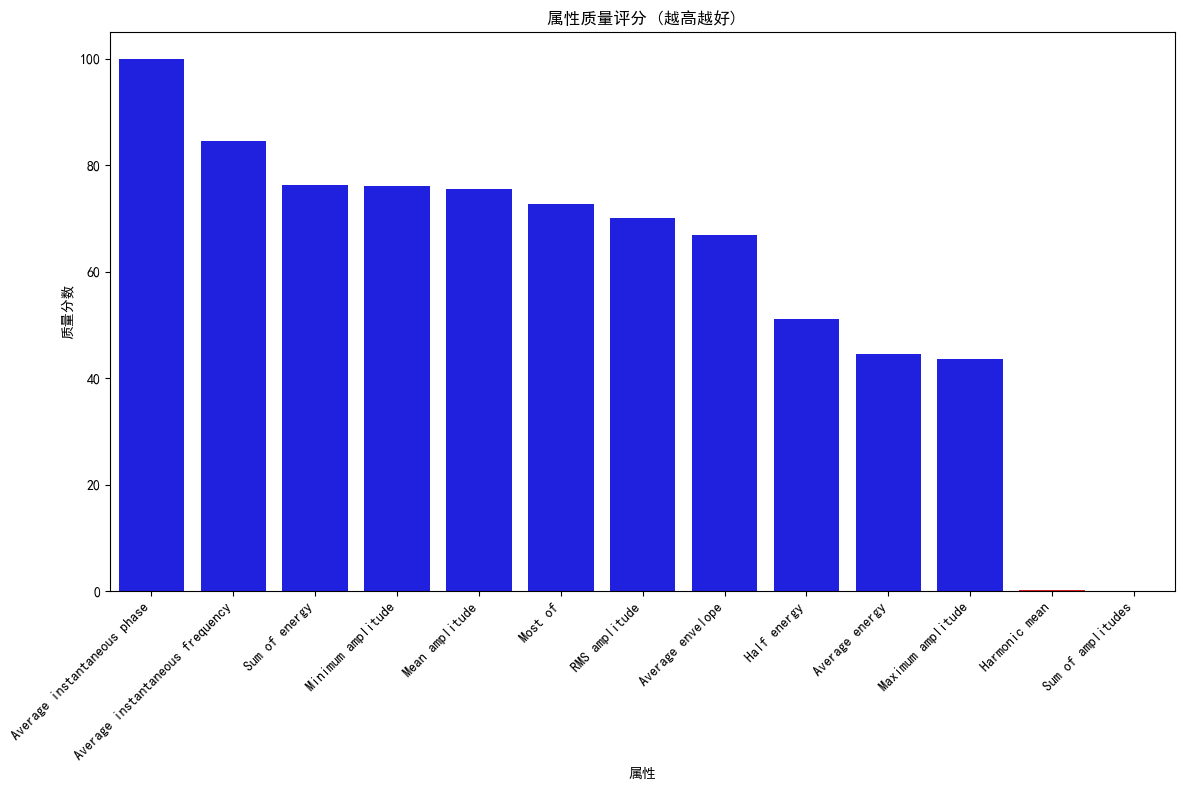


筛选后保留的质量良好属性:
- Maximum amplitude
- Average energy
- Average envelope
- Minimum amplitude
- Half energy
- Most of
- Mean amplitude
- RMS amplitude
- Average instantaneous frequency
- Sum of energy
- Average instantaneous phase


In [6]:
# 筛选出质量良好的属性
good_attributes, anomalous_attributes, attribute_stats = filter_anomalous_attributes(
    seismic_data=data_H6_2_attr_filtered,
    well_data=data_H6_2_well_selected,
    common_attributes=common_attributes,
    ratio_threshold=5.0,  # 均值比值阈值
    range_ratio_threshold=10.0,  # 数值范围比值阈值
    std_ratio_threshold=10.0,  # 标准差比值阈值
    output_dir=output_dir,  # 输出图表目录
    verbose=True,  # 打印详细信息
)

print("\n筛选后保留的质量良好属性:")
for attr in good_attributes:
    print(f"- {attr}")

## 相关性分析

======== 随机森林特征重要性分析与冗余特征移除 ========
全特征模型性能: MSE = 19.1175, R² = 0.1424

全部特征重要性排序:
1. Maximum amplitude: 0.371362
2. Minimum amplitude: 0.235785
3. RMS amplitude: 0.111280
4. Average energy: 0.058807
5. Sum of energy: 0.058005
6. Half energy: 0.042649
7. Average instantaneous phase: 0.039722
8. Most of: 0.023269
9. Average instantaneous frequency: 0.021651
10. Mean amplitude: 0.021233
11. Average envelope: 0.016239


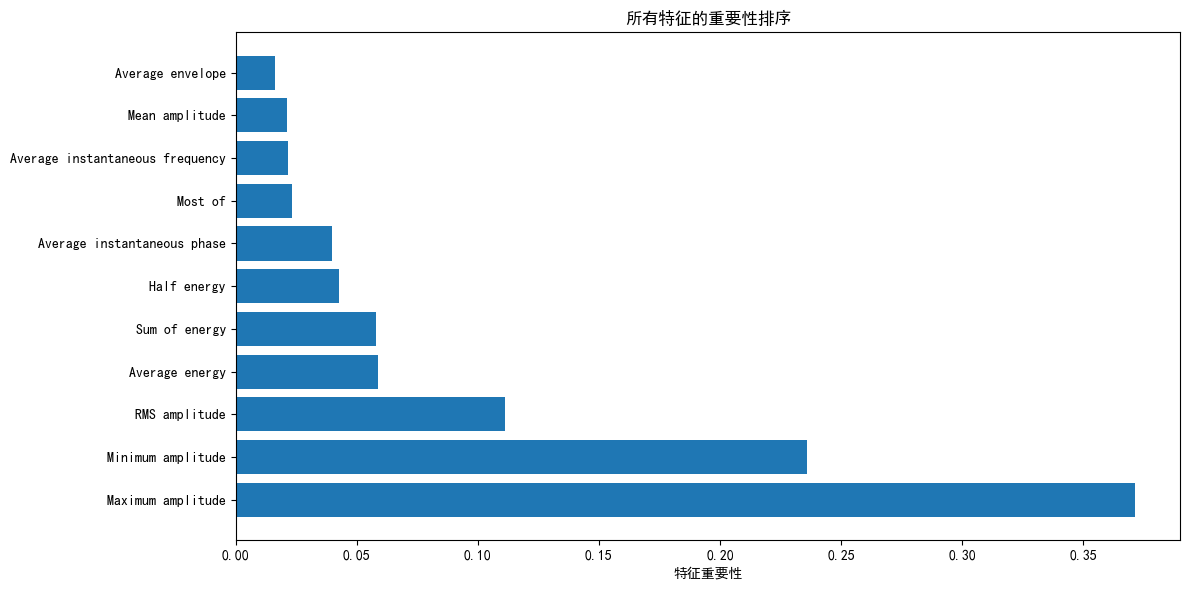

添加特征: Maximum amplitude (重要性: 0.371362)
添加特征: Minimum amplitude (重要性: 0.235785)
添加特征: RMS amplitude (重要性: 0.111280)
特征 'Average energy' 与已选特征 'RMS amplitude' 相关性过高 (0.9742)，被视为冗余
特征 'Sum of energy' 与已选特征 'Minimum amplitude' 相关性过高 (0.8926)，被视为冗余
添加特征: Half energy (重要性: 0.042649)
添加特征: Average instantaneous phase (重要性: 0.039722)


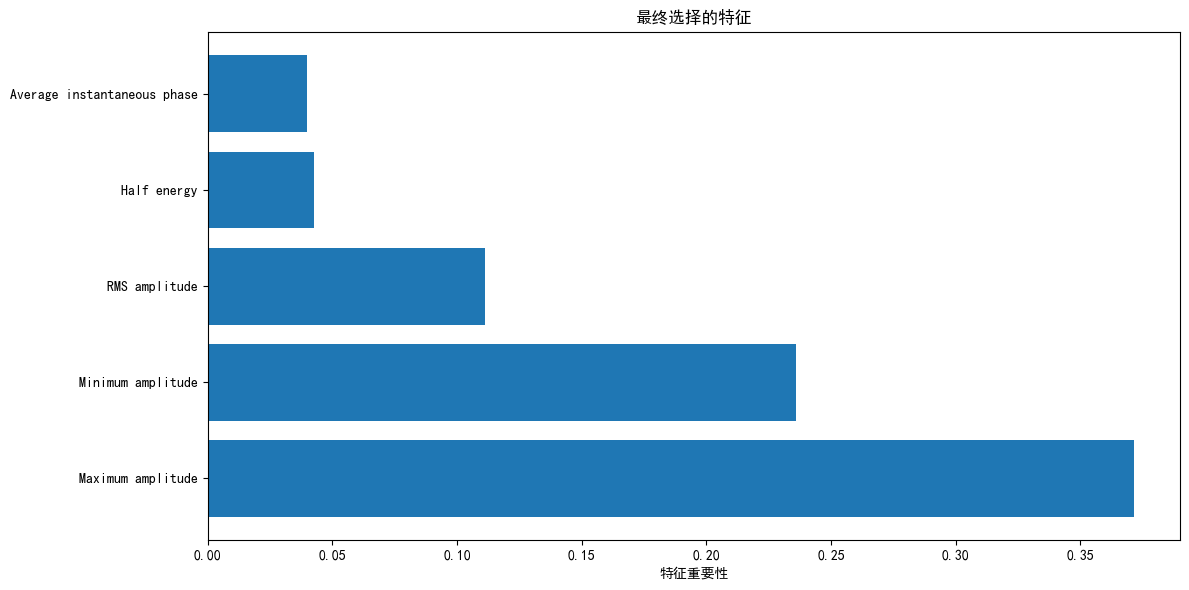


最终选择的特征列表:
1. Maximum amplitude: 0.371362
2. Minimum amplitude: 0.235785
3. RMS amplitude: 0.111280
4. Half energy: 0.042649
5. Average instantaneous phase: 0.039722

共选择了 5 个特征用于建模
======== 特征选择分析完成 ========

基于随机森林重要性和相关性分析的最佳特征:
1. Maximum amplitude
2. Minimum amplitude
3. RMS amplitude
4. Half energy
5. Average instantaneous phase


In [7]:
# 使用随机森林评估特征重要性并移除冗余特征
selected_features = select_best_features(
    well_data=data_H6_2_well_selected,
    attribute_columns=good_attributes,
    target_column="Thickness of facies(1: Fine sand)",
    n_features=5,
    corr_threshold=0.85,
    output_dir=output_dir,
    verbose=True
)

# 输出特征选择结果
print("\n基于随机森林重要性和相关性分析的最佳特征:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

## 制作融合属性

======== 创建融合属性 ========
属性 'Maximum amplitude' 与砂厚的Spearman相关性: 0.3887
属性 'Minimum amplitude' 与砂厚的Spearman相关性: -0.4810
属性 'RMS amplitude' 与砂厚的Spearman相关性: 0.4423
属性 'Half energy' 与砂厚的相关性过低 (-0.2286)，不纳入融合
属性 'Average instantaneous phase' 与砂厚的相关性过低 (-0.3305)，不纳入融合

标准化属性:
属性 'Maximum amplitude' 均值: 5417.4087, 标准差: 3620.6477
属性 'Minimum amplitude' 均值: -7549.5652, 标准差: 7541.8337
属性 'RMS amplitude' 均值: 5713.6783, 标准差: 2476.7744

融合属性与砂厚的相关性: 0.6186

在整个工区创建融合属性...
可视化融合属性分布...


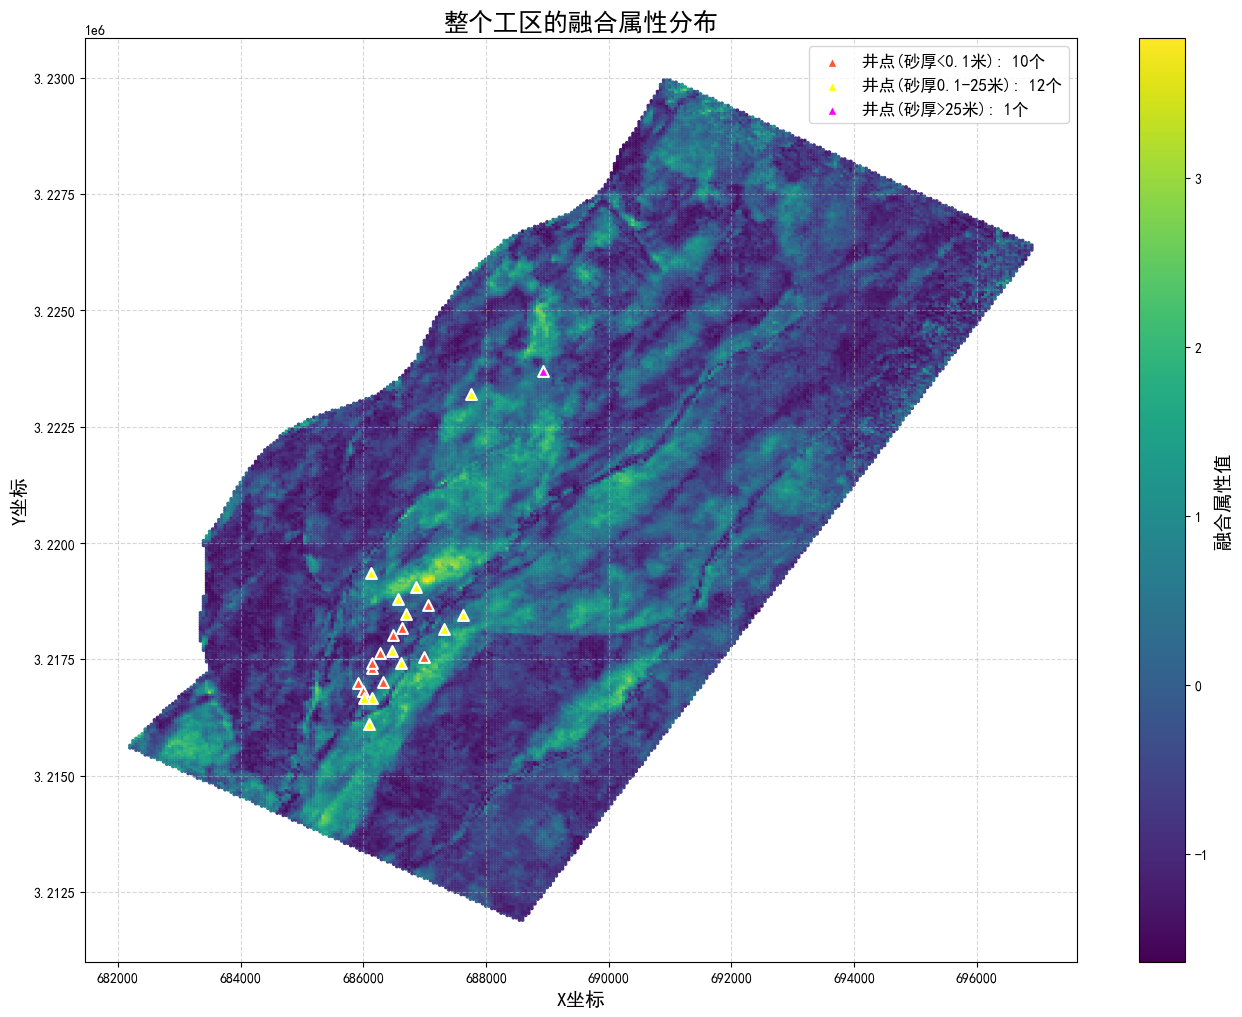

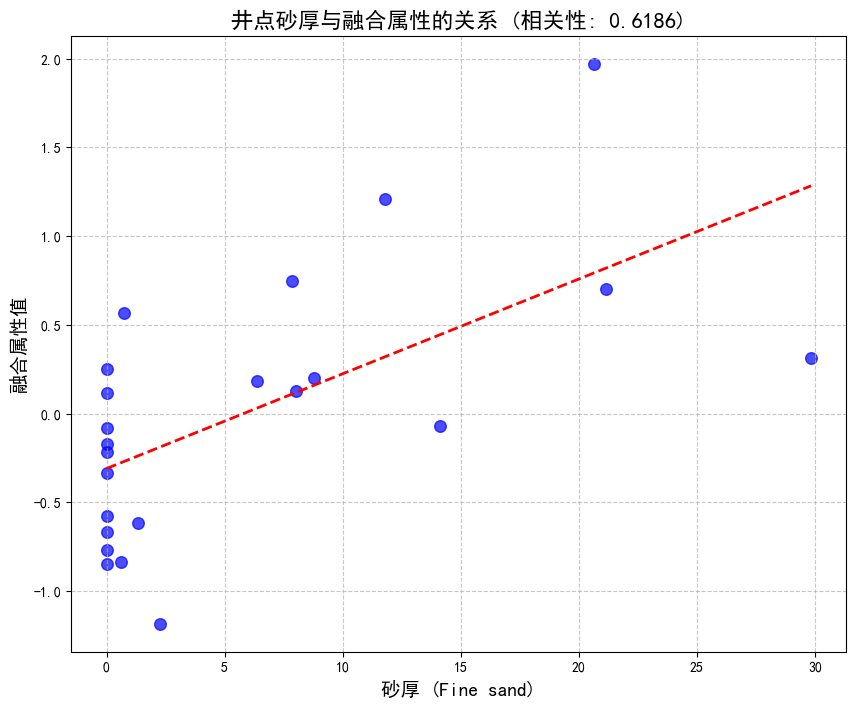


融合属性的权重组成:
属性 'Maximum amplitude': 权重 = 0.3887, 相对贡献 = 29.63%
属性 'Minimum amplitude': 权重 = -0.4810, 相对贡献 = 36.66%
属性 'RMS amplitude': 权重 = 0.4423, 相对贡献 = 33.71%

融合属性数据已保存至: output\fused_attribute_data.csv


In [26]:
# 创建融合属性
# 步骤1: 计算所选属性与砂厚的Spearman相关性
print("======== 创建融合属性 ========")
target_column = "Thickness of facies(1: Fine sand)"
correlation_weights = {}
min_corr_threshold = 0.35  # 最小相关性阈值，低于此值的属性将被排除

# 计算相关性权重
for feature in selected_features:
    corr = data_H6_2_well_selected[feature].corr(
        data_H6_2_well_selected[target_column], method="spearman"
    )
    # 使用绝对值，因为负相关也是一种关系
    abs_corr = abs(corr)
    # 如果相关性低于阈值，则不考虑此属性
    if abs_corr >= min_corr_threshold:
        # 保存原始相关性符号，以便后续调整权重的正负
        correlation_weights[feature] = corr
        print(f"属性 '{feature}' 与砂厚的Spearman相关性: {corr:.4f}")
    else:
        print(f"属性 '{feature}' 与砂厚的相关性过低 ({corr:.4f})，不纳入融合")

# 步骤2: 标准化所有选定属性
# 这一步骤确保不同范围的属性可以合理融合
print("\n标准化属性:")
normalized_features = {}

# 首先在井点数据上计算每个属性的均值和标准差
feature_stats = {}
for feature in correlation_weights.keys():
    feature_mean = data_H6_2_well_selected[feature].mean()
    feature_std = data_H6_2_well_selected[feature].std()
    feature_stats[feature] = {"mean": feature_mean, "std": feature_std}
    print(f"属性 '{feature}' 均值: {feature_mean:.4f}, 标准差: {feature_std:.4f}")

# 步骤3: 创建融合属性函数
def create_fused_attribute(data, features, weights, stats):
    """
    基于选定特征和权重创建融合属性

    参数:
        data (DataFrame): 包含特征的数据框
        features (list): 特征列表
        weights (dict): 每个特征的权重
        stats (dict): 每个特征的标准化统计信息

    返回:
        Series: 融合属性
    """
    # 初始化融合属性
    fused_attr = np.zeros(len(data))
    total_weight = 0

    # 对每个特征进行标准化并加权融合
    for feature in features:
        if feature in weights:
            # 标准化
            normalized_feature = (data[feature] - stats[feature]["mean"]) / stats[feature]["std"]
            # 根据相关性方向调整权重
            weight = weights[feature]
            # 累加
            fused_attr += normalized_feature * weight
            total_weight += abs(weight)

    # 归一化融合结果
    if total_weight > 0:
        fused_attr = fused_attr / total_weight

    return fused_attr

# 步骤4: 在井点数据上创建并验证融合属性
fused_attribute_well = create_fused_attribute(
    data_H6_2_well_selected,
    correlation_weights.keys(),
    correlation_weights,
    feature_stats
)

# 检查融合属性与目标的相关性
fused_target_corr = np.corrcoef(
    fused_attribute_well,
    data_H6_2_well_selected[target_column]
)[0, 1]

print(f"\n融合属性与砂厚的相关性: {fused_target_corr:.4f}")

# 步骤5: 在整个工区的地震数据上创建融合属性
print("\n在整个工区创建融合属性...")
fused_attribute_seismic = create_fused_attribute(
    data_H6_2_attr,  # 注意这里使用原始的大工区数据
    correlation_weights.keys(),
    correlation_weights,
    feature_stats
)

# 添加融合属性到地震数据中
data_H6_2_attr["Fused_Attribute"] = fused_attribute_seismic

# 步骤6: 可视化整个工区的融合属性分布
print("可视化融合属性分布...")
plt.figure(figsize=(16, 12))

# 创建散点图，颜色代表融合属性值
scatter = plt.scatter(
    data_H6_2_attr["X"],
    data_H6_2_attr["Y"],
    c=data_H6_2_attr["Fused_Attribute"],
    cmap="viridis",
    s=3,  # 点的大小
)

# 将井点按砂厚分为三类
low_sand = data_H6_2_well_selected[data_H6_2_well_selected[target_column] < 0.1]
medium_sand = data_H6_2_well_selected[(data_H6_2_well_selected[target_column] >= 0.1) &
                                     (data_H6_2_well_selected[target_column] <= 25)]
high_sand = data_H6_2_well_selected[data_H6_2_well_selected[target_column] > 25]

# 标记不同类别的井点位置（选择在viridis色谱上对比鲜明的颜色）
plt.scatter(
    low_sand["X"], low_sand["Y"],
    color='#FF5733',  # 红橙色
    s=60,
    marker="^",
    label=f"井点(砂厚<0.1米): {len(low_sand)}个",
    edgecolors='white',
    linewidth=1.5,
    zorder=10
)

plt.scatter(
    medium_sand["X"], medium_sand["Y"],
    color='#FFFF00',  # 黄色
    s=60,
    marker="^",
    label=f"井点(砂厚0.1-25米): {len(medium_sand)}个",
    edgecolors='white',
    linewidth=1.5,
    zorder=10
)

plt.scatter(
    high_sand["X"], high_sand["Y"],
    color='#FF00FF',  # 品红色
    s=60,
    marker="^",
    label=f"井点(砂厚>25米): {len(high_sand)}个",
    edgecolors='white',
    linewidth=1.5,
    zorder=10
)

# 添加颜色条
colorbar = plt.colorbar(scatter)
colorbar.set_label("融合属性值", fontsize=14)

# 添加标题和标签
plt.title("整个工区的融合属性分布", fontsize=18)
plt.xlabel("X坐标", fontsize=14)
plt.ylabel("Y坐标", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper right", fontsize=12)

# 保存图片
plt.savefig(os.path.join(output_dir, "fused_attribute_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()

# 步骤7: 对比井点数据中的砂厚与融合属性的关系
plt.figure(figsize=(10, 8))
plt.scatter(
    data_H6_2_well_selected[target_column],
    fused_attribute_well,
    alpha=0.7,
    s=70,
    color="blue"
)

# 添加趋势线
z = np.polyfit(data_H6_2_well_selected[target_column], fused_attribute_well, 1)
p = np.poly1d(z)
plt.plot(
    np.sort(data_H6_2_well_selected[target_column]),
    p(np.sort(data_H6_2_well_selected[target_column])),
    "r--",
    linewidth=2
)

plt.title(f"井点砂厚与融合属性的关系 (相关性: {fused_target_corr:.4f})", fontsize=16)
plt.xlabel("砂厚 (Fine sand)", fontsize=14)
plt.ylabel("融合属性值", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)

# 保存图片
plt.savefig(os.path.join(output_dir, "sandstone_thickness_vs_fused_attribute.png"), dpi=300, bbox_inches="tight")
plt.show()

# 输出融合属性权重信息
print("\n融合属性的权重组成:")
total_abs_weight = sum(abs(w) for w in correlation_weights.values())
for feature, weight in correlation_weights.items():
    relative_weight = abs(weight) / total_abs_weight * 100
    print(f"属性 '{feature}': 权重 = {weight:.4f}, 相对贡献 = {relative_weight:.2f}%")

# 如果需要，可以将带有融合属性的数据导出到CSV文件
data_H6_2_attr[["X", "Y", "Z", "Fused_Attribute"]].to_csv(
    os.path.join(output_dir, "fused_attribute_data.csv"),
    index=False
)
print(f"\n融合属性数据已保存至: {os.path.join(output_dir, 'fused_attribute_data.csv')}")